<a href="https://colab.research.google.com/github/JSJeong-me/KOSA-Big-Data_Vision/blob/main/Model/09-29-lgbm-pcs-mutate-corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Microsoft https://github.com/microsoft/LightGBM

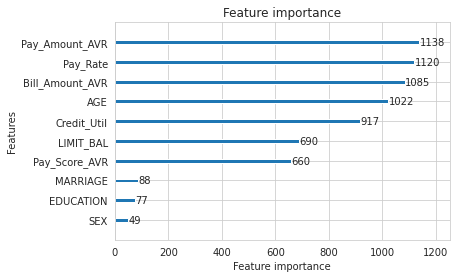

In [1]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

In [2]:
#Import data
df = pd.read_csv('./credit_cards_pca.csv')

In [3]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Pay_AVR',
       'Bill_AVR', 'P_AMT_AVR', 'default.payment.next.month'],
      dtype='object')

Mutate Variable I : Credit Utilize

In [4]:
df['Credit_Util'] = (df['Bill_AVR'] / df['LIMIT_BAL'])*100

In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Pay_AVR',
       'Bill_AVR', 'P_AMT_AVR', 'default.payment.next.month', 'Credit_Util'],
      dtype='object')

In [6]:
df['Credit_Util'].describe()

count    30000.000000
mean       -63.177296
std        177.382164
min      -1131.471832
25%        -89.887148
50%        -35.267329
75%         21.189695
max        773.172464
Name: Credit_Util, dtype: float64

Mutate Variable 2 : Bill to Pay Rate

In [7]:
df['Pay_Rate'] = (df['P_AMT_AVR'] / df['Bill_AVR'])

In [8]:
df['Pay_Rate'].describe()

count    30000.000000
mean        -0.305677
std         41.620972
min      -6834.448681
25%         -0.016120
50%          0.079590
75%          0.118993
max        302.001406
Name: Pay_Rate, dtype: float64

In [9]:
df['Pay_Rate'].std()

41.62097188167064

In [10]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
Pay_AVR                       0
Bill_AVR                      0
P_AMT_AVR                     0
default.payment.next.month    0
Credit_Util                   0
Pay_Rate                      0
dtype: int64

In [11]:
df['Pay_Rate'].describe()

count    30000.000000
mean        -0.305677
std         41.620972
min      -6834.448681
25%         -0.016120
50%          0.079590
75%          0.118993
max        302.001406
Name: Pay_Rate, dtype: float64

In [12]:
#df['Pay_Rate'].replace([np.inf, -np.inf, np.nan], 1, inplace=True)

In [13]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Pay_AVR',
       'Bill_AVR', 'P_AMT_AVR', 'default.payment.next.month', 'Credit_Util',
       'Pay_Rate'],
      dtype='object')

In [14]:
#df = df.drop(['ID', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'Credit_Util', 'Pay_Rate'], axis = 1)

In [15]:
col_list = list(df.columns)

In [16]:
col_list

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'Pay_AVR',
 'Bill_AVR',
 'P_AMT_AVR',
 'default.payment.next.month',
 'Credit_Util',
 'Pay_Rate']

In [17]:
new_col = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Pay_AVR', 'Bill_AVR', 'P_AMT_AVR', 'Pay_Rate', 'Credit_Util', 'default.payment.next.month']

In [18]:
new_col

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'Pay_AVR',
 'Bill_AVR',
 'P_AMT_AVR',
 'Pay_Rate',
 'Credit_Util',
 'default.payment.next.month']

In [19]:
df = df[new_col]

In [20]:
df = df.drop(['ID'], axis = 1)

In [21]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Pay_AVR',
       'Bill_AVR', 'P_AMT_AVR', 'Pay_Rate', 'Credit_Util',
       'default.payment.next.month'],
      dtype='object')

In [23]:
df.shape

(30000, 11)

In [24]:
#Split in 75% train and 25% test set
train_df, test_df = train_test_split(df, test_size = 0.3, random_state= 42)

In [25]:
#Define 'y' labels
train_y = train_df['default.payment.next.month']
test_y = test_df['default.payment.next.month']

In [26]:
#Define 'x' sets
train_x = train_df.drop('default.payment.next.month', axis = 1)
test_x = test_df.drop('default.payment.next.month', axis = 1)

In [27]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x, label=train_y)

In [28]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

In [29]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [30]:
# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [31]:
# View the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [32]:
# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 16, 'num_leaves': 27, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.7869999999999999


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    8.9s finished


In [33]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 27, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


In [34]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 1
                 )

In [35]:
#Predict on test set
predictions_lgbm_prob = lgbm.predict(test_x)

In [36]:
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

Overall accuracy of Light GBM model: 0.8103333333333333


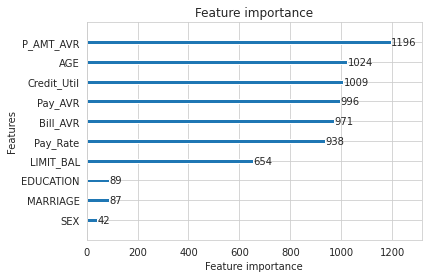

In [37]:
#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

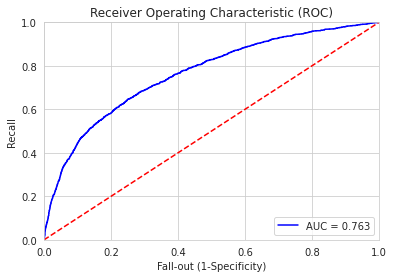

AUC score: 0.7631099257884972


<Figure size 432x288 with 0 Axes>

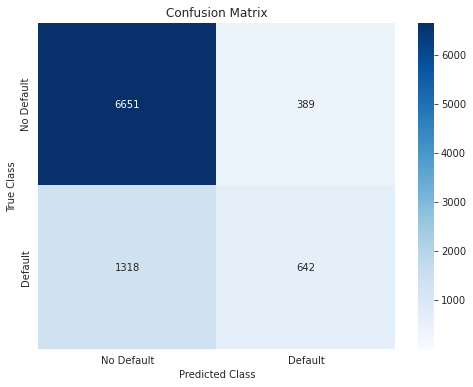

In [38]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_y, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [40]:
accuracy = accuracy_score(test_y, predictions_lgbm_01)
cm = confusion_matrix(test_y, predictions_lgbm_01)
precision = precision_score(test_y,predictions_lgbm_01)
recall = recall_score(test_y,predictions_lgbm_01)

In [41]:
print(accuracy)
print(cm)
print(precision)
print(recall)

0.8103333333333333
[[6651  389]
 [1318  642]]
0.6226964112512124
0.32755102040816325


In [ ]:
df.corr()

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

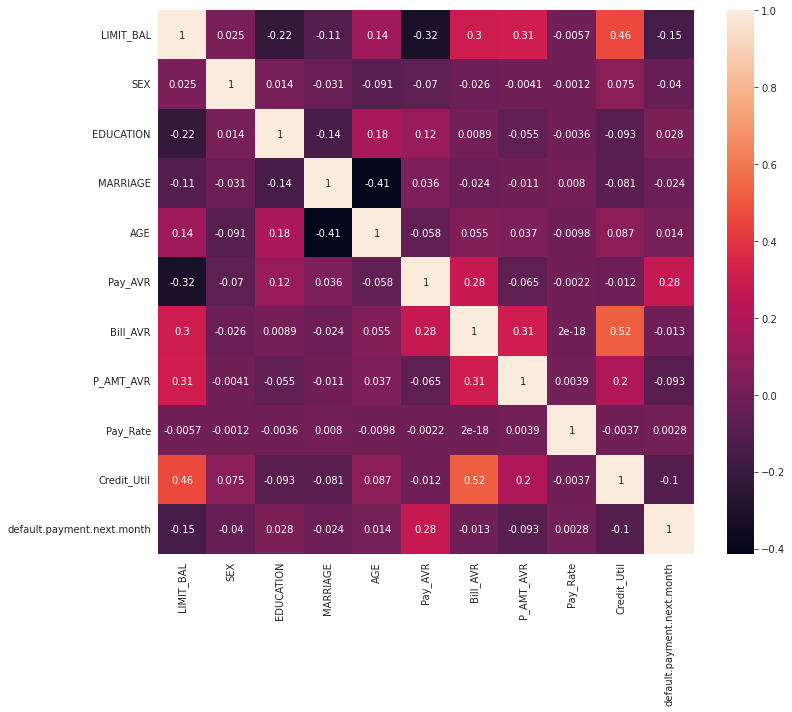

In [45]:
plt.subplots(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr,annot=True)
plt.show()